# Lab Session 2
# Generative Adversarial Networks (GANs)

In this lab session, we will explore **generative models** and in particular, we will build a Generative Adversarial Network. GANs are basically neural networks that learn to generate samples (synthetic data) that are very similar to some input data. In this exercise, we build and train a simple GAN that can generate new images (handwritten digits) that resemble a set of training images (taken from MNIST dataset). In a way, we are teaching a neural network how to write.

### Recap on GANs

GANs consist of two different neural networks (models). 
The first network is called the **discriminator** and is a standard binary classifier that determines whether an image looks like a real one (taken from the dataset) or a fake one (not present in the training set). 
The second network is called the **generator**. It takes random noise as input and transforms it into images using a neural network. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

The continuous process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake can be described as a minimax game:
$$\underset{G}{\text{min}}\; \underset{D}{\text{max}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. This minimax game is shown to be related to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

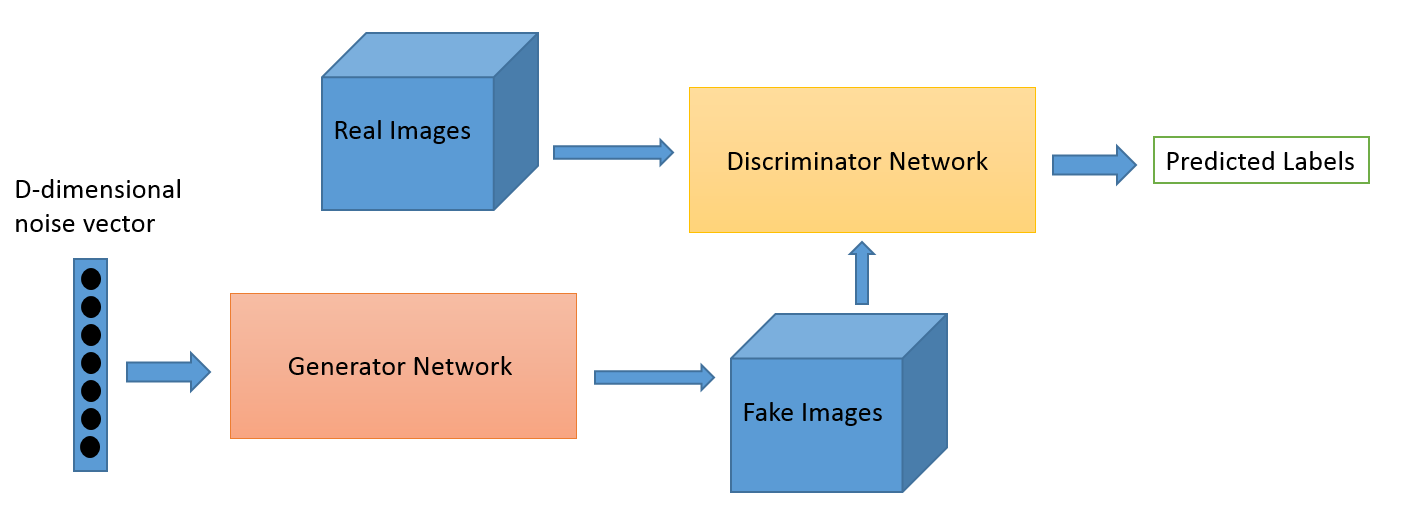

To optimize this minimax game, we alternate between taking gradient descent steps on the objective for $G$, and gradient ascent steps on the objective for $D$:
1. update $G$ to minimize the probability of the __discriminator making the correct choice__. 
2. update $D$ to maximize the probability of the __discriminator making the correct choice__.

As we discussed during the lecture, we update the generator as maximizing the probability of the **discriminator making the incorrect choice**. That way, we alleviate the vanishing gradient problem of the generator. Therefore, in this exercise, we alternate the following updates:
1. Update $G$ to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{max}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update $D$, to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{max}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$


### Lab Session Objective and Output: 
You will need to complete the notebooks by performing all tasks (7 implementation tasks and 2 questions related to a qualitative assessment of your results).

## Initial Setup and Imports

In [1]:
using Plots
using Flux

## Loading Dataset (MNIST data)
For simplicity and computational convenience, we use the MNIST dataset. This dataset contains real handwritten digits and 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students. Each picture contains a centered image of white digit on black background (0 through 9). 

In [2]:
# show a batch
# mnist = MNIST(batch_size=16) 
# show_images(mnist.X[:16])

## Activation Function
We implement below the neural network function. To avoid potential issues from ReLU, we will implement Leaky ReLU.

In [3]:
function leaky_relu(x; alpha=0.01)
    # Compute the leaky ReLU activation function
    # Inputs:
    # - x: Julia Array with arbitrary shape
    # - alpha: leak parameter for leaky ReLU
    # Output:
    # - y: a Julia Array with the same shape as x

    # TASK 1 TODO: Implement a leaky ReLU activation function
    # Element-wise maximum operation
    y = max.(x, alpha .* x)  # Using broadcasting for element-wise operations
    return y
end

leaky_relu (generic function with 1 method)

## Random Noise
In the cell below, we will generate a random uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [4]:
using Random

function random_noise(batch_size, dim)
    """
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the noise to generate
    Output:
    - noise: a Julia Array containing uniform noise in [-1, 1] with shape (batch_size, dim)
    """

    # Task 2 TODO: sample from and return random noise (uniform)
    noise = 2 * rand(batch_size, dim) .- 1  # Generate uniform noise from [-1, 1]
    return noise
end

random_noise (generic function with 1 method)

## Discriminator
First, we will implement the first neural network, the discriminator. To build the model, we will use the layers in `tf.layers`. The architecture we adopt is as follows:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and should contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [5]:
function discriminator(x)
    # Create the model using Flux's Chain
    model = Chain(
        Dense(784, 256), # Fully connected layer from 784 to 256
        x -> leakyrelu(x, 0.01), # LeakyReLU with alpha 0.01
        Dense(256, 256), # Fully connected layer from 256 to 256
        x -> leakyrelu(x, 0.01), # LeakyReLU with alpha 0.01
        Dense(256, 1) # Fully connected layer from 256 to 1
    )

    # Apply the model to the input x
    logits = model(x)

    return logits
end

discriminator (generic function with 1 method)

In [6]:
# Example usage
# x = rand(Float32, 784, 64) # Random batch of 64 images, each flattened to 784
# logits = discriminator(x)
# println(size(logits)) # Should print (1, 64) as the output size


## Generator
Second, we will build the generator in a similar way as the discriminator. The architecure we adopt is:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * Tanh 

In [7]:
function generator(z)
    # Create the model using Flux's Chain
    model = Chain(
        Dense(size(z, 2), 1024), # Fully connected layer from noise dimension to 1024
        Flux.relu, # ReLU activation function
        Dense(1024, 1024), # Fully connected layer from 1024 to 1024
        Flux.relu, # ReLU activation function
        Dense(1024, 784), # Fully connected layer from 1024 to 784
        tanh # Tanh activation function to scale the output between -1 and 1
    )

    # Apply the model to the input z
    img = model(z)

    return img
end

generator (generic function with 1 method)

In [8]:
# Example usage
# z = randn(Float32, 64, 100) # Random batch of 64 noise vectors, each of 100 dimensions
# img = generator(z)
# println(size(img)) # Should print (784, 64) as the output size

# GAN Loss

We will implement below the loss of the GAN. 

The generator loss is:

$$\mathcal{L}_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

The discriminator loss is:

$$\mathcal{L}_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

For computing the loss function, we will use the sigmoid cross entropy loss.

In [9]:
function gan_loss(logits_real, logits_fake)
    """
    Inputs:
    - logits_real: Array, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Array, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Outputs:
    - D_loss: discriminator loss [scalar]
    - G_loss: generator loss [scalar]
    """

    # Using Flux's binary cross entropy loss with logit (automatically applies sigmoid)
    # Discriminator loss - Real images should be classified as real
    D_loss_real = mean(Flux.binarycrossentropy.(logits_real, ones(size(logits_real))))
    # Discriminator loss - Fake images should be classified as fake
    D_loss_fake = mean(Flux.binarycrossentropy.(logits_fake, zeros(size(logits_fake))))
    # Total discriminator loss
    D_loss = D_loss_real + D_loss_fake

    # Generator loss - Generator aims for discriminator to classify fake images as real
    G_loss = mean(Flux.binarycrossentropy.(logits_fake, ones(size(logits_fake))))

    return D_loss, G_loss
end

gan_loss (generic function with 1 method)

In [10]:
# Example usage
# batch_size = 64
# logits_real = randn(Float32, batch_size, 1)  # Random discriminator outputs for real images
# logits_fake = randn(Float32, batch_size, 1)  # Random discriminator outputs for fake images

# D_loss, G_loss = gan_loss(logits_real, logits_fake)
# println("Discriminator Loss: $D_loss, Generator Loss: $G_loss")


# Optimizer
For the loss optimization, we will implement an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. If you want to see a 'pathological' mode in GANs, you can beta1=0.9. That way, the discriminator loss might go to zero (i.e., learns too fast) and the generator might fail completely to learn. 
You can also experiment with other optimizers (e.g., SGD with Momentum or RMSProp). 

In [11]:
# Task 6 TODO: Implement an AdamOptimizer for D_opt and G_opt
function gan_optimizers(learning_rate=1e-3, beta1=0.5)
    """
    Create optimizers for GAN training.
    Inputs:
    - learning_rate: learning rate to use for both optimizers
    - beta1: beta parameter for both optimizers (first moment decay)
    
    Outputs:
    - D_opt: instance of Flux.Optimise.ADAM with correct learning_rate and beta1
    - G_opt: instance of Flux.Optimise.ADAM with correct learning_rate and beta1
    """
    
    # The default value for beta2 in ADAM in Flux is 0.999 which is commonly used
    D_opt = ADAM(learning_rate, (beta1, 0.999))
    G_opt = ADAM(learning_rate, (beta1, 0.999))

    return D_opt, G_opt
end

gan_optimizers (generic function with 3 methods)

In [12]:
# Example usage
# D_opt, G_opt = gan_optimizers(1e-3, 0.5)
# println("Discriminator Optimizer: ", D_opt)
# println("Generator Optimizer: ", G_opt)


## GAN Composition
In the below cell, we compose the generator and discriminator by using the previous functions

In [13]:
# number of images for each batch
batch_size = 128
# random noise dimension
noise_dim = 96

# Initialize models
z = random_noise(batch_size, noise_dim)
G_sample = generator(z)

# Mock `x` input representing training data
x = rand(Float32, 784, batch_size)

# Evaluate discriminator outputs
logits_real = discriminator(2 * x .- 1.0)
logits_fake = discriminator(G_sample)

# Get optimizers and losses
D_opt, G_opt = gan_optimizers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# Training steps
ps = Flux.params(G_sample) # Collect parameters from the generator
D_train_step = () -> Flux.train!(D_loss, ps, data, D_opt)
G_train_step = () -> Flux.train!(G_loss, ps, data, G_opt)

# Simulating training steps
data = [(x, G_sample)] # Mock data tuple for training

for i in 1:10  # Training loop for demonstration
    D_train_step()
    G_train_step()
end

LoadError: DimensionMismatch: layer Dense(96 => 1024) expects size(input, 1) == 96, but got 128×96 Matrix{Float64}

In [14]:
function show_images(images; img_size=(28, 28), nrows=4, ncols=4)
    # Function to plot images in a grid, assumes images are flattened
    images = reshape(images, img_size..., size(images, 2))
    p = plot(size=(600, 600), layout=(nrows, ncols), color=:gray)
    for i in 1:nrows*ncols
        plot!(p[i], images[:, :, i], seriestype=:heatmap, yflip=true, axis=nothing)
    end
    display(p)
end

show_images (generic function with 1 method)

# Time to train our GAN!
It is not time to start training our GAN. We use a simple procedure. We train D(x) and G(z) with one batch each every iteration. Training could take several minutes if run on a CPU.

In [15]:
function run_a_gan(G_train_step, G_loss, D_train_step, D_loss, 
                   show_every=2, print_every=1, batch_size=128, num_epoch=10)
    # Load MNIST data
    train_x, _ = MLDatasets.MNIST.traindata(Float32)
    train_x = reshape(train_x, 28 * 28, :)

    # Training loop
    for epoch in 1:num_epoch
        if epoch % show_every == 0
            z = random_noise(batch_size, noise_dim)  # noise_dim must be defined globally or passed
            samples = generator(z)
            show_images(samples[:, 1:16])
        end

        # Iterate over the dataset
        for i in 1:batch_size:size(train_x, 2)-batch_size
            minibatch = train_x[:, i:i+batch_size-1]
            x = minibatch * 2 .- 1  # Scale images to [-1, 1]
            z = random_noise(batch_size, noise_dim)

            # Update Discriminator
            Flux.train!(D_loss, params(D_train_step), [(minibatch,)], D_opt)

            # Update Generator
            Flux.train!(G_loss, params(G_train_step), [(z,)], G_opt)
        end

        if epoch % print_every == 0
            @info "Epoch: $epoch, D: $(mean(D_loss)), G: $(mean(G_loss))"
        end
    end

    # Final images display
    z = random_noise(batch_size, noise_dim)
    samples = generator(z)
    show_images(samples[:, 1:16])
end

run_a_gan (generic function with 5 methods)

In [16]:
# Specify the number of epochs directly in the function call or handle it inside the function
num_epochs = 10
batch_size = 128  # Specify your batch size
print_every = 1
show_every = 2

# Call the GAN training function
run_a_gan(G_train_step, G_loss, D_train_step, D_loss,
          show_every=show_every, print_every=print_every, batch_size=batch_size, num_epoch=num_epochs)


LoadError: UndefVarError: `G_train_step` not defined

# GAN2: Changing the loss function and the divergence 
We will now implement a GAN with a different loss function. Specifically, we will implement the following objective functions for 
the generator loss:
$$\mathcal{L}_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \mathcal{L}_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
This GAN variant is known as Least Squares GAN, which substitutes the binary cross entropy loss with a least square ($\ell_2$) loss, which has better properties for optimization and is less likely to saturate. It has been shown that minimizing the above objective functions yields minimizing the Pearson $\chi^2$ divergence.

In [17]:
using Flux

function gan2_loss(score_real, score_fake)
    """
    Inputs:
    - score_real: Array, shape [batch_size, 1], output of discriminator scoring real images
    - score_fake: Array, shape [batch_size, 1], output of discriminator scoring fake images
    
    Outputs:
    - D_loss: discriminator loss (scalar)
    - G_loss: generator loss (scalar)
    """

    # Using sigmoid cross-entropy loss functions
    D_loss_real = Flux.binarycrossentropy.(Flux.σ.(score_real), ones(size(score_real)))
    D_loss_fake = Flux.binarycrossentropy.(Flux.σ.(score_fake), zeros(size(score_fake)))
    
    # Discriminator loss combines real loss and fake loss
    D_loss = mean(D_loss_real) + mean(D_loss_fake)
    
    # Generator tries to fool the discriminator, so it tries to increase the mistake on fake images
    G_loss = mean(Flux.binarycrossentropy.(Flux.σ.(score_fake), ones(size(score_fake))))

    return D_loss, G_loss
end

gan2_loss (generic function with 1 method)

In [18]:
# Example use-case:
# batch_size = 128
# score_real = randn(Float32, batch_size, 1)  # Simulated scores for real images
# score_fake = randn(Float32, batch_size, 1)  # Simulated scores for fake images

# D_loss, G_loss = gan2_loss(score_real, score_fake)
# println("Discriminator Loss: ", D_loss, ", Generator Loss: ", G_loss)

Create new training steps to minimize the new GAN loss:

In [19]:
# Assuming that D_loss and G_loss are already computed using previously defined gan2_loss function
# Assuming that D_opt and G_opt are instances of optimizers, for example, created using ADAM
# Assuming logits_real and logits_fake are outputs from your discriminator

# Define models and load parameters
# Assuming you have your models (discriminator and generator)
discriminator_model = ...  # Your discriminator model definition
generator_model = ...  # Your generator model definition

# Collect parameters from both models
D_vars = params(discriminator_model)  # Collects all trainable parameters in the discriminator
G_vars = params(generator_model)      # Collects all trainable parameters in the generator

# Function to update the discriminator
function D_train_step()
    grads = gradient(() -> D_loss, D_vars)
    Flux.Optimise.update!(D_opt, D_vars, grads)
end

# Function to update the generator
function G_train_step()
    grads = gradient(() -> G_loss, G_vars)
    Flux.Optimise.update!(G_opt, G_vars, grads)
end

# Example call to training functions within a training loop
for epoch in 1:10
    # Update Discriminator
    D_train_step()

    # Update Generator
    G_train_step()

    # Optionally print losses or validate here
end

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///Users/valiha/Developer/MALCOM/Labs/Lab 2/In[19]#7:23\[90mIn[19]:7:23[0;0m]8;;\
# Assuming you have your models (discriminator and generator)
discriminator_model = [48;2;120;70;70m...[0;0m  # Your discriminator model definition
[90m#                     └─┘ ── [0;0m[91minvalid identifier[0;0m

Run the below cell to train the model:

In [20]:
using Flux

# Assuming generator and discriminator models are already defined along with optimizers and losses
generator_model = generator()  # your generator model function
discriminator_model = discriminator()  # your discriminator model function

# Initialize models (if necessary, depending on model definitions)
Flux.@functor generator_model
Flux.@functor discriminator_model

# Define the training loop
function run_a_gan(G_train_step, G_loss, D_train_step, D_loss, num_epochs=10)
    for epoch in 1:num_epochs
        # Perform training steps
        D_train_step()
        G_train_step()

        # Display samples or log progress at certain intervals
        if epoch % 2 == 0
            # Display or evaluate generator outputs here
            println("Epoch $epoch: Displaying generated samples...")
            # You can add code here to generate and display images using generator_model
        end

        if epoch % 1 == 0
            println("Epoch $epoch: D Loss: $(mean(D_loss)), G Loss: $(mean(G_loss))")
        end
    end
end

# Setup optimizers (if not already done)
D_opt, G_opt = gan_optimizers()  # Adjusted function to setup GAN optimizers

# Define loss computations (adapt to Julia)
D_loss, G_loss = gan2_loss(discriminator_model, generator_model)

# Define training steps (using closures to capture and update the model states)
D_train_step = () -> Flux.train!(D_loss, params(discriminator_model), data, D_opt)
G_train_step = () -> Flux.train!(G_loss, params(generator_model), data, G_opt)

# Start the training process
run_a_gan(G_train_step, G_loss, D_train_step, D_loss)


LoadError: MethodError: no method matching generator()

[0mClosest candidates are:
[0m  generator([91m::Any[39m)
[0m[90m   @[39m [36mMain[39m [90m[4mIn[7]:1[24m[39m


# Qualitative Results:
Task 8 TODO: Please comment on the visual quality of the samples and how the results change over different training runs.

Task 9 TODO: Re-train the first GAN architecture with random Gaussian noise instead of uniform. Please comment on the performance of the GAN and on the visual quality of the samples (during the course of the training).